In [1]:
import math
import numpy as np
import tensorflow as tf
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
tf.__version__

'2.13.0'

In [3]:
Ticker  = 'TATAMOTORS.NS'
start = '2015-01-01'
end = '2023-10-16'

In [4]:
df = yf.download(Ticker, start, end)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,489.252289,494.149750,487.026154,493.160370,491.429077,944551
2015-01-02,491.973083,511.909271,491.973083,506.368683,504.591034,4193093
2015-01-05,504.686737,520.417969,501.322815,518.241333,516.421997,6758676
2015-01-06,508.891632,508.891632,493.951874,496.079071,494.337524,7979598
2015-01-07,489.746979,495.089661,484.008514,488.609192,486.893890,9232656
...,...,...,...,...,...,...
2023-10-09,620.799988,622.000000,613.700012,617.349976,617.349976,6381189
2023-10-10,620.000000,632.500000,617.599976,630.549988,630.549988,9833429
2023-10-11,633.000000,637.799988,632.599976,634.000000,634.000000,7701931


In [5]:
df.to_csv('TATA.csv')

In [6]:
df=pd.read_csv('TATA.csv')

In [7]:
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,489.252289,494.149750,487.026154,493.160370,491.429077,944551
1,2015-01-02,491.973083,511.909271,491.973083,506.368683,504.591034,4193093
2,2015-01-05,504.686737,520.417969,501.322815,518.241333,516.421997,6758676
3,2015-01-06,508.891632,508.891632,493.951874,496.079071,494.337524,7979598
4,2015-01-07,489.746979,495.089661,484.008514,488.609192,486.893890,9232656


In [8]:
df.tail()


,Date,Open,High,Low,Close,Adj Close,Volume
2165,2023-10-09,620.799988,622.000000,613.700012,617.349976,617.349976,6381189
2166,2023-10-10,620.000000,632.500000,617.599976,630.549988,630.549988,9833429
2167,2023-10-11,633.000000,637.799988,632.599976,634.000000,634.000000,7701931
2168,2023-10-12,637.000000,640.200012,635.049988,636.950012,636.950012,5928732
2169,2023-10-13,633.950012,669.000000,633.000000,667.099976,667.099976,28011678


In [9]:
df1=df.reset_index()['Close']

In [10]:
df1


0       493.160370
1       506.368683
2       518.241333
3       496.079071
4       488.609192
           ...    
2165    617.349976
2166    630.549988
2167    634.000000
2168    636.950012
2169    667.099976
Name: Close, Length: 2170, dtype: float64

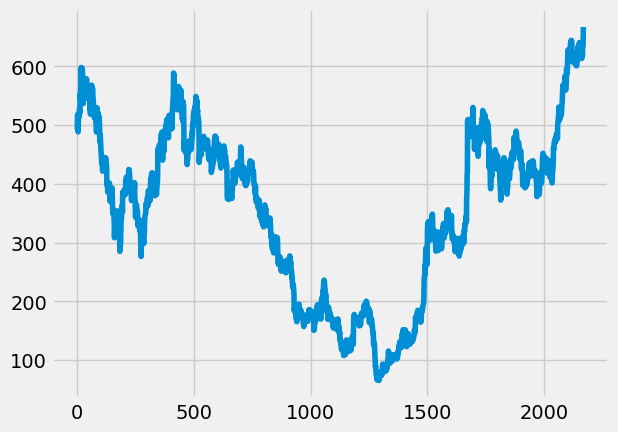

In [11]:
plt.plot(df1)

In [12]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
print(df1)

[[0.71096774]
 [0.73291575]
 [0.75264432]
 ...
 [0.94499838]
 [0.94990036]
 [1.        ]]


In [14]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [15]:
training_size,test_size

(1410, 760)

In [16]:
train_data

array([[0.71096774],
       [0.73291575],
       [0.75264432],
       ...,
       [0.13683947],
       [0.13725489],
       [0.11989032]])

In [17]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [18]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
print(X_train.shape), print(y_train.shape)


(1309, 100)
(1309,)


(None, None)

In [20]:
print(X_test.shape), print(ytest.shape)


(659, 100)
(659,)


(None, None)

In [21]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [22]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
mymo = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=10,batch_size=1,verbose=1)

Epoch 1/10
1309/1309 [==============================] - 37s 16ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 2/10
1309/1309 [==============================] - 18s 14ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 3/10
1309/1309 [==============================] - 19s 15ms/step - loss: 7.5874e-04 - val_loss: 0.0028
Epoch 4/10
1309/1309 [==============================] - 20s 15ms/step - loss: 5.4271e-04 - val_loss: 3.1136e-04
Epoch 5/10
1309/1309 [==============================] - 19s 15ms/step - loss: 4.5231e-04 - val_loss: 6.3091e-04
Epoch 6/10
1309/1309 [==============================] - 19s 14ms/step - loss: 4.1006e-04 - val_loss: 0.0012
Epoch 7/10
1309/1309 [==============================] - 18s 14ms/step - loss: 4.4811e-04 - val_loss: 3.1604e-04
Epoch 8/10
1309/1309 [==============================] - 19s 15ms/step - loss: 3.6984e-04 - val_loss: 3.3886e-04
Epoch 9/10
1309/1309 [==============================] - 18s 14ms/step - loss: 3.6309e-04 - val_loss: 4.2136e-04
Epoch 10/10
1309

In [25]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

21/21 [==============================] - 0s 6ms/step


In [26]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [27]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

324.631520616906

In [28]:
math.sqrt(mean_squared_error(ytest,test_predict))

428.4906344233538

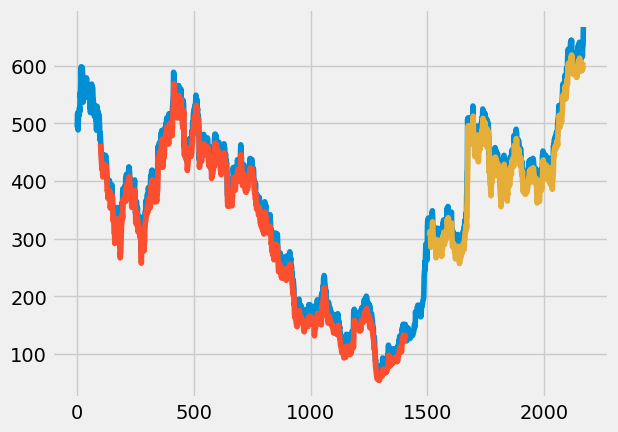

In [29]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [30]:
len(test_data)

760

In [31]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 419)

In [32]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [33]:
temp_input

[0.7233300480535244,
 0.7133599578676874,
 0.710285836584954,
 0.7244101310148898,
 0.7347125778244552,
 0.7204221050826553,
 0.6748920367094332,
 0.7289797556833985,
 0.7197574425456997,
 0.722249965092159,
 0.7109504991219097,
 0.7131107157551417,
 0.6861914519691813,
 0.6841143498471319,
 0.602608882862115,
 0.6554503405628506,
 0.6459787346021051,
 0.6352609180786308,
 0.6178132602534161,
 0.5848288684131718,
 0.5461947689430535,
 0.5424559851233646,
 0.5659687710028634,
 0.5887338305447248,
 0.5863243717989473,
 0.5756065552754731,
 0.5788468041595695,
 0.5975407232580138,
 0.6123296802249053,
 0.602608882862115,
 0.6232137257707445,
 0.6156530436201842,
 0.6113327117747224,
 0.6095048517652186,
 0.6105018709259027,
 0.6121635526235422,
 0.6154038015076384,
 0.6122466164242236,
 0.6245430508446557,
 0.6338484784935371,
 0.6526254613926631,
 0.6494682763092482,
 0.6384181031620457,
 0.6426553712068261,
 0.6426553712068261,
 0.619807247864283,
 0.6077600555563967,
 0.612329680224905

In [34]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=418
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

0 day input [0.71335996 0.71028584 0.72441013 0.73471258 0.72042211 0.67489204
 0.72897976 0.71975744 0.72224997 0.7109505  0.71311072 0.68619145
 0.68411435 0.60260888 0.65545034 0.64597873 0.63526092 0.61781326
 0.58482887 0.54619477 0.54245599 0.56596877 0.58873383 0.58632437
 0.57560656 0.5788468  0.59754072 0.61232968 0.60260888 0.62321373
 0.61565304 0.61133271 0.60950485 0.61050187 0.61216355 0.6154038
 0.61224662 0.62454305 0.63384848 0.65262546 0.64946828 0.6384181
 0.64265537 0.64265537 0.61980725 0.60776006 0.61232968 0.59762384
 0.62354603 0.63600864 0.6207212  0.59795614 0.61415754 0.60643073
 0.61606846 0.6186441  0.61075111 0.59521438 0.59986707 0.57037222
 0.56272852 0.54245599 0.53647392 0.51013626 0.56331007 0.56505487
 0.59629446 0.58133933 0.55392158 0.58607513 0.59180795 0.59895316
 0.58441345 0.59047858 0.60535065 0.62662015 0.62853108 0.63027587
 0.62121969 0.6091725  0.60992027 0.61573616 0.6154038  0.60352279
 0.60277501 0.56729815 0.56472251 0.57959458 0.54445

In [35]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [36]:
len(df1)

2170

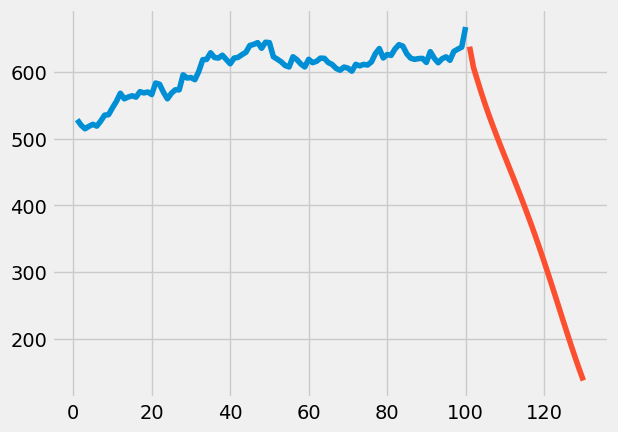

In [37]:
plt.plot(day_new,scaler.inverse_transform(df1[2070:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

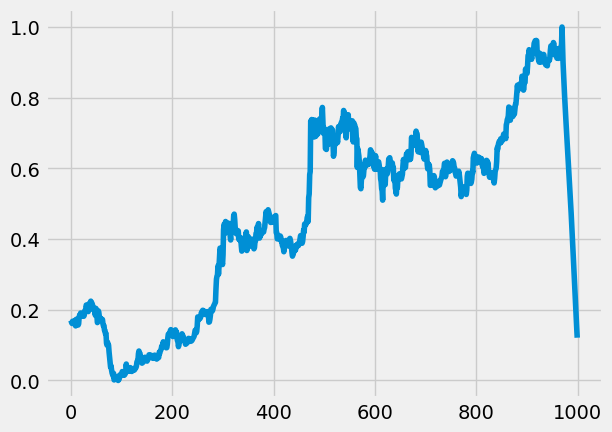

In [38]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [39]:
df3=scaler.inverse_transform(df3).tolist()

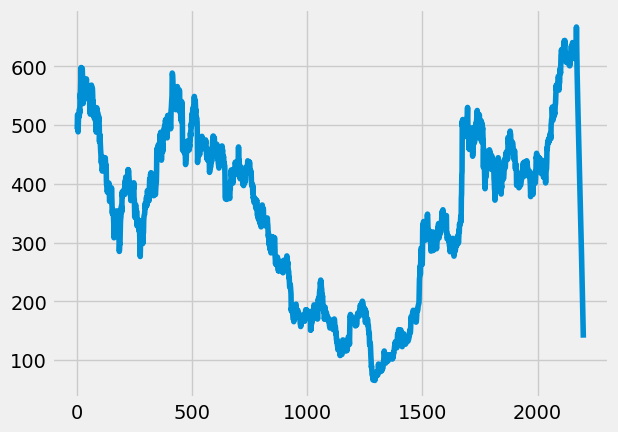

In [40]:
plt.plot(df3)

In [41]:
import pickle
pickle.dump(model,open('spp.pkl','wb'))

In [42]:
model1 = pickle.load(open('spp.pkl', 'rb'))
variable_names = [var.name for var in model1.trainable_weights]

# Print the variable names
for name in variable_names:
    print(name)

lstm/lstm_cell/kernel:0
lstm/lstm_cell/recurrent_kernel:0
lstm/lstm_cell/bias:0
lstm_1/lstm_cell/kernel:0
lstm_1/lstm_cell/recurrent_kernel:0
lstm_1/lstm_cell/bias:0
lstm_2/lstm_cell/kernel:0
lstm_2/lstm_cell/recurrent_kernel:0
lstm_2/lstm_cell/bias:0
dense/kernel:0
dense/bias:0
